# 1. 데이터수집
- 수집 사이트 : https://coinmarketcap.com/ko/historical/
- 데이터 주기 : Weekly
- 데이터 내용 : 암호화폐 이름, 가격, 시가총액, 날짜, 공급량, 거래량 등

1. Library importing

In [119]:
import json
import time
import datetime as dt
import requests
from bs4 import BeautifulSoup
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.wait import WebDriverWait
import time

from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys

2. date_list 만들기. Why? 각 날짜별 다른 URL로 접속해서 크롤링을 해와야 하는데, 이 때 URL을 반복문으로 만들어주기 위함.

In [120]:
url = 'https://coinmarketcap.com/ko/historical/'

first_date = dt.date(2013, 4, 28)

date = first_date # start date
today = dt.date.today() # end date
date_list = []
while(date < today):
    date_list.append(date)
    date = date + relativedelta(days = 7)

date_str_list = []
for _date in date_list:
    date_str_list.append(_date.strftime("%Y%m%d"))

3. 크롤링 해오기

- 특이사항 : 동적 크롤링을 해야한다. Why? 해당 페이지의 경우에는 정적인 페이지가 아니고, 스크롤을 하면 HTML코드가 바뀐다. 또한 우리는 그 바뀐 내용을 가지고 와야 하기 때문에 동적 크롤링을 해 주어야 한다.
* 크롤링 순서
(1) 홈페이지 URL 접속
(2) 맨 위부터 맨 아래까지 천천히 스크롤하여, HTML코드를 우리가 가져올 형태로 변환시킴
(3) 변환된 HTML코드를 크롤링하여, 필요한 정보를 추출함.

아래는 본격적인 크롤링 전, 홈페이지에서 스크롤을 해주는 코드이다. 여기에서는 whileSeconds에 시간(초)를 넣어주면, 그 시간동안 천천히 스크롤 하여 크롤링을 하게 된다. 파라미터 driver는 여기서 사용할 ChromeDriver 객체를 넣어주면 된다. 이 객체를 통해서 우리는 Google chrome을 열고, 이를 이용하여 동적 크롤링을 진행한다.(with package called "selenium")

In [121]:
# scroll test 1
def doScrollDown(whileSeconds, driver):
    start = dt.datetime.now()
    end = start + dt.timedelta(seconds=whileSeconds)
    scroll_unit = 500
    now = 0
    while True:
        driver.execute_script('window.scrollTo(' + str(now) +  ',' + str(now+scroll_unit) + ');')
        time.sleep(1)
        now = now + scroll_unit
        if dt.datetime.now() > end:
            break

이제 스크롤도 마쳤겠다. 크롤링을 본격적으로 해오는 단계이다. 아래 코드는 크롤링을 수행하는 코드이다. 이 안에 스크롤 --> 크롤링 --> 데이터 저장(into pandas dataframe)의 과정이 포함되어 있다.

In [122]:
# 크롤링한 데이터를 넣을 dataframe
df = pd.DataFrame(columns = ['date', 'rank', 'name', 'symbol', 'size', 'price', 'circulating_supply', 'volume-24-h'])

# 크롤링 구체적 특성. 크롤링을 직접 할 것이면, 궁금해해도 되는데, 딱히 안궁금해하는 것을 추천.
columns = [['left', 'rank'], ['left', 'name'], ['left', 'symbol'], ['right', 'market-cap'], ['right', 'price'], ['right', 'circulating-supply'], ['right', 'volume-24-h']]
for date in date_str_list[-2:]:
    print(date)
    _url = url + date
    # dynamic crawling(with scroll)
    options = Options() # 브라우저를 렌더링하지 않고 메모리 상에서만 작업이 이루어지기 위한 옵션
    options.headless = True
    driver = webdriver.Chrome(executable_path='./chromedriver.exe') # , options = options)
    driver.get(_url)
    time.sleep(5)
    actions = ActionChains(driver)
    last_height = driver.execute_script("return document.body.scrollHeight")
    
    
    doScrollDown(18, driver)
#     # scroll test 2
#     while(True):
#         for _ in range(10):
#             actions.send_keys(Keys.SPACE).perform()
#             time.sleep(0.5)
#         new_height = driver.execute_script("return document.body.scrollHeight")
#         if new_height == last_height:
#             break
#         last_height = new_height
#     print("loading complete")
#     driver.execute_script("window.scrollTo(0, 0);")
#     time.sleep(3)
    
    
#     req = requests.get(_url)
#     html = req.text
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    del driver
    del options
    rows = soup.findAll('tr', {"class":"cmc-table-row"})
    data = []
    noneFlag = False
    for row in rows:
        tmp = []
        tmp.append(date)
        for col in columns:
            if col[0] == 'left':
                if col[1] != 'symbol':
                    class_name = 'cmc-table__cell cmc-table__cell--sticky cmc-table__cell--sortable cmc-table__cell--' + col[0] + ' cmc-table__cell--sort-by__' + col[1]
                else:
                    class_name = 'cmc-table__cell cmc-table__cell--sortable cmc-table__cell--' + col[0] + ' cmc-table__cell--sort-by__' + col[1]
            elif col[0] == 'right':
                class_name = 'cmc-table__cell cmc-table__cell--sortable cmc-table__cell--' + col[0] + ' cmc-table__cell--sort-by__' + col[1]
            r = row.find('td', {"class": class_name})
            try:
                tmp.append(r.text)
                print(r.text)
            except:
                if col[1] != 'volume-24-h':
                    noneFlag = True
                else:
                    tmp.append(None)
            if noneFlag:
                break
        if noneFlag == False:
            data.append(tmp)
    df = pd.concat([df, pd.DataFrame(data, columns = ['date', 'rank', 'name', 'symbol', 'size', 'price', 'circulating_supply', 'volume-24-h'])], ignore_index = True)

20210606


KeyboardInterrupt: 

크롤링한 데이터를 pandas dataframe 형태로 갖고 있다. 일단 이 데이터를 excel로 저장해 준다.

In [ ]:
df.to_excel('./data_preprocessed')

위 데이터는 깔끔하지 못한 데이터이다. 이를 이용하여 우리는 전처리를 할 필요가 있다. 간단한 전처리를 한 후 데이터를 다시 저장할 것이다.

In [ ]:
df = pd.read_excel('./crawling_data_20210609.xlsx')

여기서 데이터가 이상한 경우가 있다. 갑자기 \?를 갖고 있는 이상한 경우가 발생하는데, 이 원인은 아직 정확히 파악되지 않은 상태지만 그 양이 적기 때문에 일단 missing value로 처리하고 dropna를 해준다.

이후 각 데이터들의 이상한 부분을 각 타입에 맞게 고쳐준다. 주로 text형태의 숫자들을 int형태로 바꿔주었다.

In [ ]:
df['volume-24-h'] = df['volume-24-h'].apply(lambda x: np.nan if x=='₩?' else x)
df.dropna(axis = 0, inplace = True)
df['date'] = pd.to_datetime(df['date'], format = "%Y%m%d")
df['size'] = df['size'].apply(lambda x: float(x.split('₩')[-1].replace(',', '')))
tmp = df['symbol'].apply(lambda x: str(len(x)))
df['name'] = df['name'] + tmp
df['name'] = df['name'].apply(lambda x: x[int(x[-1]):-1])
df['price'] = df['price'].apply(lambda x : float(x.split('₩')[-1].replace(',','')))
df['circulating_supply'] = df['circulating_supply'].apply(lambda x : int(x.split()[0].replace(',','')))
df['volume-24-h'] = df['volume-24-h'].apply(lambda x: x.replace('₩','').replace(',',''))
df['volume-24-h']= pd.to_numeric(df['volume-24-h'])
df.dropna(axis = 0, inplace = True)
df.reset_index(drop = True, inplace = True)
df = df.iloc[:,1:]

가격 분포를 찍어보도록 하겠다.

In [ ]:
df[df['symbol'] == 'BTC']['size'].plot()
plt.show()
df[df['symbol'] == 'ETH']['size'].plot()
plt.show()
df[df['symbol'] == 'USDT']['size'].plot()
plt.show()
df[df['symbol'] == 'ADA']['size'].plot()
plt.show()
df[df['symbol'] == 'BNB']['size'].plot()
plt.show()

In [ ]:
df[df['symbol'] == 'BTC']['size'].plot()
df[df['symbol'] == 'ETH']['size'].plot()
df[df['symbol'] == 'USDT']['size'].plot()
df[df['symbol'] == 'ADA']['size'].plot()
df[df['symbol'] == 'BNB']['size'].plot()
plt.show()

마지막으로, 전처리된 데이터를 저장한다.

In [ ]:
df.to_csv('./data_preprocessed.csv', index = False)

# 2. Factor 만들기

### (1) Momentum관련

In [287]:
import pdb
from collections import defaultdict

In [358]:
data = pd.read_csv('./data_preprocessed.csv')

In [427]:
# data_raw = data[data['price'] >= 1000]
data_raw = data[(data['rank'] <= 30) & (data['date'] >= '2016-01-01')]
# data_raw = data[(data['date'] >= '2016-01-01')]

In [428]:
# data_raw = pd.read_csv('./data_preprocessed.csv')
data_raw['market_cap'] = data_raw['circulating_supply']*data_raw['price']
data_preprocessed = data_raw.copy()

c:\users\administrator\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [429]:
data_preprocessed = data_preprocessed.reset_index()
data_preprocessed = data_preprocessed.drop(['index'],axis=1)

In [430]:
data_preprocessed['NVT'] = data_preprocessed['volume-24-h']/data_preprocessed['market_cap']

In [431]:
date_list = list(data_raw['date'].unique())

아래 함수는 factor를 만들어주는 함수이다. 해당 factor_name에 대해 t시점과 t+t_n시점 사이의 변화율(%)를 기록하여 list로 출력해주는 역할을 한다.

In [432]:
def factor_make(data_raw,t_n,factor_name='price'):
    
    price_return_list = []

    for date_index in range(len(date_list)):
        # index out of range error를 방지하기 위한 조건문.
        # 예를 들어, t_n이 음수이면, 앞부분의 몇개를 비워놔야 될 것. 양수이면 뒷부분!
        # 비워놔야 그 series를 이용해서 무언가를 구하던가 하겠지!
        # 따라서 그런 에러를 유발하지 않는 date_index를 사용하겠다!는 의도.
        if ( ((date_index>= -t_n) & (t_n < 0)) | ((date_index<len(date_list)-t_n) &(t_n>0))) :
            
            # 현재 date와 t_n일 뒤(또는 앞)의 데이터를 비교하겠다.
            compare_day = data_raw[data_raw['date']==date_list[date_index+t_n]] 
            now_day = data_raw[data_raw['date']==date_list[date_index]]

            compare_day.columns =compare_day.columns +'_compare'
            now_day.columns =now_day.columns+'_now_day'
            
            # symbol_compare에서 중복된 행이 있을 경우, 제거
            compare_day = compare_day.drop_duplicates(subset=['symbol_compare'])
            
            # now와 compare를 merge해준다. 
            all_frame_m = pd.merge(now_day, compare_day, left_on='symbol_now_day', right_on='symbol_compare', how='left')
#             pdb.set_trace()
            
            # 상대적으로 미래/과거 값으로 return을 만들어준다.
            # 꼭 factor가 price가 아니어도, 변화율을 보여준다.
            if t_n<0:
                price_return_temp = np.log(all_frame_m[f'{factor_name}_now_day']/all_frame_m[f'{factor_name}_compare'])
            else:
                price_return_temp = np.log(all_frame_m[f'{factor_name}_compare']/all_frame_m[f'{factor_name}_now_day'])
            
            price_return_list =price_return_list +list(price_return_temp)
        
        # index out of range error가 뜨는 경우, 이를 nan으로 채워놓자.
        else:
            
            now_day = data_raw[data_raw['date']==date_list[date_index]]
            price_return_list = price_return_list + [np.nan]*len(now_day)
    
    return price_return_list

In [433]:
def rank_weighted_factor_return(data_temp,factor='market_cap'):
    data_temp = data_temp.sort_values(by=[f'{factor}']) # factor에 대해 sorting하고,
    data_temp = data_temp.reset_index() # index를 reset 한 후,
    weight_array=np.array(data_temp.index)-np.mean(np.array(data_temp.index)) # i - mean
    weight_array = weight_array/(np.sum(abs(weight_array))/2) # 비율로 만들어줬음.
    
    factor_return_series = np.array(data_temp['t_1_lead'])*weight_array
    factor_return_series = factor_return_series[~np.isnan(factor_return_series)]
    
    if len(factor_return_series)!=0:
        return np.sum(factor_return_series)
    else:
        return 0 

In [ ]:
def make_factor_raw_data(_data, factor_col_name, cut_num):
    nested_dict = lambda: defaultdict(nested_dict)
    raw_dict = nested_dict()
    
    _data = _data.iloc[_data[factor_col_name].dropna().index]
    date_list = list(_data['date'].unique())
    
    for d in date_list:
        sorted_data = _data[_data.date == d].sort_values(factor_col_name, ascending=False)
        factor_col = pd.qcut(sorted_data[factor_col_name], cut_num)
        group_data = sorted_data.groupby(factor_col)
        
        for i ,f in  enumerate(factor_col.values.unique()):
            if i == cut_num:
                break
#             pdb.set_trace()
            raw_dict[d]['p'+str(i+1)] = group_data.get_group(f)
            
    return raw_dict

In [ ]:
def make_factor_return(raw_dict):
    ew_ret_df = pd.DataFrame()
    vw_ret_df = pd.DataFrame()
    for d, port in raw_dict.items():
        for p, data in port.items():
            raw_data = raw_dict[d][p]
            equal_w_ret = raw_data.t_1_lead.mean()
            value_w_ret = (raw_data.t_1_lead * raw_data.market_cap).sum() / raw_data.market_cap.sum()
            ew_ret_df.loc[d, p] = equal_w_ret
            vw_ret_df.loc[d, p] = value_w_ret
            
    return ew_ret_df, vw_ret_df

In [ ]:
def plot_logreturn(data1):
    data1.cumsum(axis=0).plot()
    plt.show()

In [486]:
data_preprocessed['t_3_return_mom'] = pd.Series(factor_make(data_raw=data_preprocessed,t_n=-8,factor_name='price'))
# data_preprocessed['t_12_return_value'] = -pd.Series(factor_make(data_raw=data_preprocessed,t_n=-12,factor_name='price'))
# data_preprocessed['t_12_market_cap_value'] = -pd.Series(factor_make(data_raw=data_preprocessed,t_n=-12,factor_name='market_cap'))
# data_preprocessed['t_12_NVT']= pd.Series(factor_make(data_raw=data_preprocessed,t_n=-12,factor_name='NVT'))
data_preprocessed['t_1_lead'] = pd.Series(factor_make(data_raw=data_preprocessed,t_n=1,factor_name='price'))


2중 dictionary를 만들어줌. 내용 안에는 날짜 -> 포트폴리오 -> 그룹별 value

In [487]:
cut_num = 3
mom_dict = make_factor_raw_data(data_preprocessed, 't_3_return_mom', cut_num)
# value_return_dict = make_factor_raw_data(data_preprocessed, 't_12_return_value', cut_num)
# value_marketcap_dict = make_factor_raw_data(data_preprocessed, 't_12_market_cap_value', cut_num)
# value_NVT_dict = make_factor_raw_data(data_preprocessed, 't_12_NVT', cut_num)

아래 함수는 날짜별 그룹 return을 뽑아줌

In [488]:
ew_mom_df, vw_mom_df = make_factor_return(mom_dict)
# ew_vr_df, vw_vr_df = make_factor_return(value_return_dict)
# ew_vm_df, vw_vm_df = make_factor_return(value_marketcap_dict)
# ew_nvt_df, vw_nvt_df = make_factor_return(value_NVT_dict)

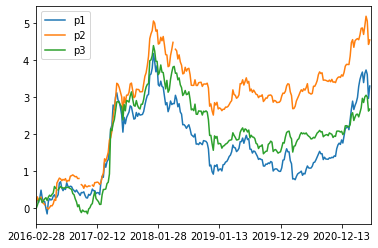

In [489]:
plot_logreturn(ew_mom_df)

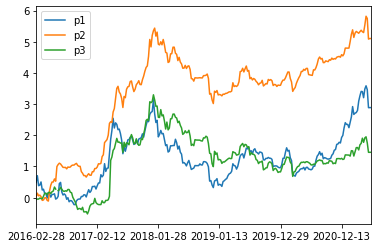

In [490]:
plot_logreturn(vw_mom_df)

### (2) Value 관련

In [17]:
###############
# factor rank weighted return

In [71]:
market_factor_rank_return = [] 
for date_temp in date_list:
    data_pre_temp = data_preprocessed[data_preprocessed['date']==date_temp]
    print(data_pre_temp)
    market_factor_rank_return.append(rank_weighted_factor_return(data_temp=data_pre_temp,factor='market_cap'))

          date  rank       name symbol          size      price  \
0   2013-12-29     1    Bitcoin    BTC  1.014925e+13  832593.51   
1   2013-12-29     2   Litecoin    LTC  6.558607e+11   26892.77   
2   2013-12-29     3        XRP    XRP  2.377860e+11      30.42   
3   2013-12-29     4       Omni   OMNI  1.248842e+11  201595.87   
4   2013-12-29     5   Peercoin    PPC  1.004537e+11    4787.41   
..         ...   ...        ...    ...           ...        ...   
62  2013-12-29    63   Noirbits    NRB  1.421301e+08      69.90   
63  2013-12-29    64      Spots    SPT  1.247882e+08      35.17   
64  2013-12-29    65  CraftCoin    CRC  1.086237e+08     418.96   
65  2013-12-29    66    Elacoin    ELC  8.115444e+07    1132.19   
66  2013-12-29    67     Yacoin    YAC  7.972527e+08      58.85   

    circulating_supply   volume-24-h    market_cap  t_3_return  t_12_return  \
0             12189925  2.124518e+10  1.014925e+13         NaN          NaN   
1             24387992  1.272188e+10 

[100 rows x 13 columns]
            date  rank        name symbol          size         price  \
2234  2014-06-15     1     Bitcoin    BTC  8.550313e+12  662773.90000   
2235  2014-06-15     2    Litecoin    LTC  3.257309e+11   11110.27000   
2236  2014-06-15     3         Nxt    NXT  8.527623e+10      85.28000   
2237  2014-06-15     4        Dash   DASH  5.074107e+10   11565.99000   
2238  2014-06-15     5    Peercoin    PPC  4.181868e+10    1946.51000   
...          ...   ...         ...    ...           ...           ...   
2329  2014-06-15    96  Saturncoin    SAT  9.662615e+07       0.01322   
2330  2014-06-15    97    VootCoin   VOOT  9.652630e+07       1.40000   
2331  2014-06-15    98    OctoCoin    888  9.557137e+07       4.07000   
2332  2014-06-15    99  Memorycoin    MMC  9.057017e+07      13.11000   
2333  2014-06-15   100   Kryptkoin    KTK  8.558169e+07       5.02000   

      circulating_supply   volume-24-h    market_cap  t_3_return  t_12_return  \
2234            12

[100 rows x 13 columns]
            date  rank            name  symbol          size        price  \
4314  2014-11-09     1         Bitcoin     BTC  5.475182e+12  406074.4100   
4315  2014-11-09     2             XRP     XRP  1.596335e+11       5.5100   
4316  2014-11-09     3        Litecoin     LTC  1.366726e+11    4059.4200   
4317  2014-11-09     4       BitShares     BTS  4.502096e+10      22.5100   
4318  2014-11-09     5        Dogecoin    DOGE  2.334966e+10       0.2450   
...          ...   ...             ...     ...           ...          ...   
4409  2014-11-09    96      Auroracoin     AUR  8.228717e+07      40.8500   
4410  2014-11-09    97          bitCNY  BITCNY  8.045371e+07     182.4600   
4411  2014-11-09    98     Einsteinium    EMC2  7.816357e+07       0.5128   
4412  2014-11-09    99  CzechCrownCoin     CZC  7.689998e+07      35.8200   
4413  2014-11-09   100          Myriad     XMY  7.623424e+07       0.1218   

      circulating_supply   volume-24-h    market_ca

[100 rows x 13 columns]
            date  rank          name  symbol          size          price  \
6494  2015-04-12     1       Bitcoin     BTC  3.706821e+12  263895.970000   
6495  2015-04-12     2           XRP     XRP  3.069999e+11       9.620000   
6496  2015-04-12     3      Litecoin     LTC  6.228303e+10    1634.290000   
6497  2015-04-12     4          Dash    DASH  1.944556e+10    3684.820000   
6498  2015-04-12     5       Stellar     XLM  1.502133e+10       3.120000   
...          ...   ...           ...     ...           ...            ...   
6589  2015-04-12    96  Pangea Poker  PANGEA  6.711650e+08     671.600000   
6590  2015-04-12    97      TileCoin     XTC  6.622460e+08       6.620000   
6591  2015-04-12    98     Snowballs   BALLS  5.748785e+08       0.002639   
6592  2015-04-12    99        Rimbit     RBT  5.357024e+08       4.770000   
6593  2015-04-12   100        Crypti     XCR  4.204704e+08       4.200000   

      circulating_supply   volume-24-h    market_ca

[80 rows x 13 columns]
            date  rank       name symbol          size      price  \
8754  2015-09-27     1    Bitcoin    BTC  3.812915e+12  260070.66   
8755  2015-09-27     2        XRP    XRP  2.372680e+11       7.30   
8756  2015-09-27     3   Litecoin    LTC  1.362677e+11    3208.09   
8757  2015-09-27     4   Ethereum    ETH  5.920884e+10     805.43   
8758  2015-09-27     5  BitShares    BTS  1.781387e+10       7.09   
...          ...   ...        ...    ...           ...        ...   
8849  2015-09-27    96      MMNXT  MMNXT  5.608530e+08      11.22   
8850  2015-09-27    97   FairCoin   FAIR  5.419823e+08      10.42   
8851  2015-09-27    98      Quark    QRK  5.199334e+08       2.09   
8852  2015-09-27    99  CloakCoin  CLOAK  4.790644e+08     104.12   
8853  2015-09-27   100      Swarm  SWARM  4.635863e+08       4.64   

      circulating_supply   volume-24-h    market_cap  t_3_return  t_12_return  \
8754            14661075  1.584387e+10  3.812915e+12   -0.029568   

[100 rows x 13 columns]
             date  rank               name symbol          size        price  \
10954  2016-02-28     1            Bitcoin    BTC  7.392427e+12  484379.2800   
10955  2016-02-28     2           Ethereum    ETH  5.593150e+11    7227.4600   
10956  2016-02-28     3                XRP    XRP  3.005013e+11       8.8100   
10957  2016-02-28     4           Litecoin    LTC  1.719040e+11    3845.7900   
10958  2016-02-28     5       MaidSafeCoin   MAID  4.431008e+10      97.9100   
...           ...   ...                ...    ...           ...          ...   
11049  2016-02-28    96  MediterraneanCoin    MED  1.801964e+08       4.4600   
11050  2016-02-28    97              Burst  BURST  1.680272e+08       0.1507   
11051  2016-02-28    98               Aeon   AEON  1.638479e+08      15.5300   
11052  2016-02-28    99       TransferCoin     TX  1.607472e+08      30.1400   
11053  2016-02-28   100               MAZA   MAZA  1.551987e+08       0.1792   

       circulat

             date  rank         name symbol          size        price  \
13094  2016-07-31     1      Bitcoin    BTC  1.102170e+13  698148.4100   
13095  2016-07-31     2     Ethereum    ETH  1.095456e+12   13272.6500   
13096  2016-07-31     3        Steem  STEEM  2.610575e+11    2577.3000   
13097  2016-07-31     4          XRP    XRP  2.361978e+11       6.6400   
13098  2016-07-31     5     Litecoin    LTC  2.104263e+11    4485.8800   
...           ...   ...          ...    ...           ...          ...   
13189  2016-07-31    96  Safex Token    SFT  4.710276e+08       0.2193   
13190  2016-07-31    97    LetItRide    LIR  4.653733e+08      13.8500   
13191  2016-07-31    98    Applecoin    APC  4.502945e+08      20.2100   
13192  2016-07-31    99     Anoncoin    ANC  4.466274e+08     211.6400   
13193  2016-07-31   100    UnionCoin    UNC  4.378586e+08      52.2000   

       circulating_supply   volume-24-h    market_cap  t_3_return  \
13094            15787044  1.238509e+11  1

[100 rows x 13 columns]
             date  rank          name symbol          size       price  \
15354  2017-01-08     1       Bitcoin    BTC  1.638460e+13  1018255.67   
15355  2017-01-08     2      Ethereum    ETH  1.008619e+12    11498.74   
15356  2017-01-08     3           XRP    XRP  2.531106e+11        6.97   
15357  2017-01-08     4      Litecoin    LTC  2.198213e+11     4463.90   
15358  2017-01-08     5        Monero    XMR  2.059965e+11    15054.66   
...           ...   ...           ...    ...           ...         ...   
15449  2017-01-08    96  NautilusCoin   NAUT  5.893205e+08       36.42   
15450  2017-01-08    97      Megacoin    MEC  5.747080e+08       17.48   
15451  2017-01-08    98  Asiadigicoin   ADCN  5.449290e+08       62.14   
15452  2017-01-08    99        DNotes   NOTE  5.240194e+08        4.73   
15453  2017-01-08   100        Gambit    GAM  5.202306e+08      386.40   

       circulating_supply   volume-24-h    market_cap  t_3_return  \
15354            1

[100 rows x 13 columns]
             date  rank                   name symbol          size  \
17514  2017-06-11     1                Bitcoin    BTC  5.417737e+13   
17515  2017-06-11     2               Ethereum    ETH  3.517905e+13   
17516  2017-06-11     3                    XRP    XRP  1.168450e+13   
17517  2017-06-11     4       Ethereum Classic    ETC  2.230131e+12   
17518  2017-06-11     5                    NEM    XEM  2.193137e+12   
...           ...   ...                    ...    ...           ...   
17609  2017-06-11    96  Waves Community Token    WCT  2.186527e+10   
17610  2017-06-11    97              CloakCoin  CLOAK  2.181308e+10   
17611  2017-06-11    98            Unity Ingot    UNY  2.157695e+10   
17612  2017-06-11    99               MonaCoin   MONA  2.141638e+10   
17613  2017-06-11   100            Feathercoin    FTC  2.088589e+10   

            price  circulating_supply   volume-24-h    market_cap  t_3_return  \
17514  3306338.66            16385912  1.9

[100 rows x 13 columns]
             date  rank          name symbol          size       price  \
19714  2017-11-12     1       Bitcoin    BTC  1.108636e+14  6647902.87   
19715  2017-11-12     2      Ethereum    ETH  3.291908e+13   344020.00   
19716  2017-11-12     3  Bitcoin Cash    BCH  2.606946e+13  1551746.52   
19717  2017-11-12     4           XRP    XRP  8.495563e+12      220.48   
19718  2017-11-12     5          Dash   DASH  4.603199e+12   598992.63   
...           ...   ...           ...    ...           ...         ...   
19809  2017-11-12    96          Ubiq    UBQ  5.007379e+10     1290.51   
19810  2017-11-12    97         Storj  STORJ  4.994568e+10      485.02   
19811  2017-11-12    98        Neblio   NEBL  4.993037e+10     3981.09   
19812  2017-11-12    99      FairCoin   FAIR  4.927204e+10      926.27   
19813  2017-11-12   100      MobileGo    MGO  4.854295e+10      495.19   

       circulating_supply   volume-24-h    market_cap  t_3_return  \
19714            1

[100 rows x 13 columns]
             date  rank          name symbol          size         price  \
21814  2018-04-08     1       Bitcoin    BTC  1.331825e+14  7.849842e+06   
21815  2018-04-08     2      Ethereum    ETH  4.418136e+13  4.476280e+05   
21816  2018-04-08     3           XRP    XRP  2.186440e+13  5.592700e+02   
21817  2018-04-08     4  Bitcoin Cash    BCH  1.249593e+13  7.323473e+05   
21818  2018-04-08     5      Litecoin    LTC  7.364616e+12  1.315147e+05   
...           ...   ...           ...    ...           ...           ...   
21909  2018-04-08    96           WAX   WAXP  1.172359e+11  1.893900e+02   
21910  2018-04-08    97         Storj  STORJ  1.120682e+11  8.399300e+02   
21911  2018-04-08    98     Dentacoin    DCN  1.119723e+11  3.443000e-01   
21912  2018-04-08    99           POA    POA  1.060481e+11  5.200100e+02   
21913  2018-04-08   100          TenX    PAY  1.060349e+11  1.013120e+03   

       circulating_supply   volume-24-h    market_cap  t_3_retu

[100 rows x 13 columns]
             date  rank           name symbol          size      price  \
23974  2018-09-09    21          Zcash    ZEC  6.360094e+11  133527.59   
23975  2018-09-09    22        OmiseGO    OMG  5.348685e+11    3813.80   
23976  2018-09-09    23           Lisk    LSK  4.571300e+11    4157.46   
23977  2018-09-09    24       Bytecoin    BCN  4.171896e+11       2.27   
23978  2018-09-09    25       Ontology    ONT  3.816636e+11    2071.94   
...           ...   ...            ...    ...           ...        ...   
24049  2018-09-09    96           PIVX   PIVX  5.911435e+10    1041.09   
24050  2018-09-09    97  Kyber Network    KNC  5.804974e+10     432.78   
24051  2018-09-09    98       Loopring    LRC  5.792723e+10     101.26   
24052  2018-09-09    99           NULS   NULS  5.627703e+10    1406.93   
24053  2018-09-09   100          Nexus    NXS  5.476214e+10     936.95   

       circulating_supply   volume-24-h    market_cap  t_3_return  \
23974             

             date  rank           name symbol          size       price  \
26114  2019-02-10     1        Bitcoin    BTC  7.227672e+13  4122709.64   
26115  2019-02-10     2       Ethereum    ETH  1.461407e+13   139434.86   
26116  2019-02-10     3            XRP    XRP  1.425415e+13      346.23   
26117  2019-02-10     4       Litecoin    LTC  3.160513e+12    52315.98   
26118  2019-02-10     5            EOS    EOS  2.874338e+12     3171.70   
...           ...   ...            ...    ...           ...         ...   
26209  2019-02-10    96            WAX   WAXP  3.626756e+10       38.68   
26210  2019-02-10    97      Ravencoin    RVN  3.621391e+10       12.60   
26211  2019-02-10    98  Metaverse ETP    ETP  3.595933e+10      654.13   
26212  2019-02-10    99       MonaCoin   MONA  3.544872e+10      539.66   
26213  2019-02-10   100           Dent   DENT  3.529175e+10        1.14   

       circulating_supply   volume-24-h    market_cap  t_3_return  \
26114            17531362  7.0

[100 rows x 13 columns]
             date  rank           name symbol          size        price  \
28514  2019-07-28     1        Bitcoin    BTC  1.904913e+14  10675323.39   
28515  2019-07-28     2       Ethereum    ETH  2.527382e+13    236001.01   
28516  2019-07-28     3            XRP    XRP  1.494785e+13       348.98   
28517  2019-07-28     4       Litecoin    LTC  6.306518e+12    100317.25   
28518  2019-07-28     5   Bitcoin Cash    BCH  6.216060e+12    346936.21   
...           ...   ...            ...    ...           ...          ...   
28609  2019-07-28    96           aelf    ELF  6.790420e+10       135.87   
28610  2019-07-28    97          Golem    GNT  6.744983e+10        69.94   
28611  2019-07-28    98    UnlimitedIP    UIP  6.572701e+10        53.60   
28612  2019-07-28    99  Maximine Coin    MXM  6.557453e+10        39.77   
28613  2019-07-28   100  Metaverse ETP    ETP  6.536859e+10       908.54   

       circulating_supply   volume-24-h    market_cap  t_3_retu

[100 rows x 13 columns]
             date  rank           name symbol          size       price  \
30714  2019-12-29     1        Bitcoin    BTC  1.503224e+14  8291477.78   
30715  2019-12-29     2       Ethereum    ETH  1.641895e+13   150531.47   
30716  2019-12-29     3            XRP    XRP  9.535295e+12      220.12   
30717  2019-12-29     4         Tether   USDT  4.608213e+12     1121.75   
30718  2019-12-29     5   Bitcoin Cash    BCH  4.328075e+12   237882.45   
...           ...   ...            ...    ...           ...         ...   
30809  2019-12-29    96     Breezecoin   BRZE  5.341170e+10      534.12   
30810  2019-12-29    97        MineBee     MB  5.214301e+10       28.49   
30811  2019-12-29    98          Steem  STEEM  5.190808e+10      146.08   
30812  2019-12-29    99        Zilliqa    ZIL  5.160130e+10        5.27   
30813  2019-12-29   100  DxChain Token     DX  5.092135e+10        1.02   

       circulating_supply   volume-24-h    market_cap  t_3_return  \
30714 

[100 rows x 13 columns]
             date  rank            name symbol          size        price  \
32874  2020-05-31     1         Bitcoin    BTC  1.944519e+14  10573280.63   
32875  2020-05-31     2        Ethereum    ETH  2.869390e+13    258128.71   
32876  2020-05-31     3             XRP    XRP  1.000297e+13       226.76   
32877  2020-05-31     4          Tether   USDT  9.813014e+12      1115.36   
32878  2020-05-31     5    Bitcoin Cash    BCH  4.938648e+12    268076.45   
...           ...   ...             ...    ...           ...          ...   
32969  2020-05-31    96   Matic Network  MATIC  7.875563e+10        22.94   
32970  2020-05-31    97           Velas    VLX  7.864705e+10        58.57   
32971  2020-05-31    98  Nervos Network    CKB  7.824291e+10         4.48   
32972  2020-05-31    99           Verge    XVG  7.778006e+10         4.78   
32973  2020-05-31   100           ERC20  ERC20  7.773844e+10        68.40   

       circulating_supply   volume-24-h    market_c

[100 rows x 13 columns]
             date  rank          name symbol          size        price  \
35054  2020-11-01     1       Bitcoin    BTC  2.844562e+14  15349846.52   
35055  2020-11-01     2      Ethereum    ETH  5.015819e+13    442890.64   
35056  2020-11-01     3        Tether   USDT  1.861690e+13      1117.82   
35057  2020-11-01     4           XRP    XRP  1.213401e+13       267.95   
35058  2020-11-01     5  Bitcoin Cash    BCH  5.549034e+12    298966.87   
...           ...   ...           ...    ...           ...          ...   
35149  2020-11-01    96      MonaCoin   MONA  9.281603e+10      1412.09   
35150  2020-11-01    97     Numeraire    NMR  9.214325e+10     25957.05   
35151  2020-11-01    98     Ravencoin    RVN  9.154472e+10        12.40   
35152  2020-11-01    99         Bytom    BTM  9.078115e+10        65.60   
35153  2020-11-01   100         Golem    GNT  8.779682e+10        88.62   

       circulating_supply   volume-24-h    market_cap  t_3_return  \
35054 

[100 rows x 13 columns]
             date  rank            name symbol          size        price  \
37234  2021-04-04     1         Bitcoin    BTC  1.226069e+15  65657962.76   
37235  2021-04-04     2        Ethereum    ETH  2.697583e+14   2338896.51   
37236  2021-04-04     3    Binance Coin    BNB  6.071778e+13    392911.99   
37237  2021-04-04     4          Tether   USDT  4.749465e+13      1121.22   
37238  2021-04-04     5        Polkadot    DOT  4.619925e+13     49895.26   
...           ...   ...             ...    ...           ...          ...   
37329  2021-04-04    96         Arweave     AR  1.018155e+12     30488.52   
37330  2021-04-04    97            Celo   CELO  1.016098e+12      4962.45   
37331  2021-04-04    98   Voyager Token    VGX  1.007392e+12      4531.78   
37332  2021-04-04    99  Nervos Network    CKB  9.976794e+11        40.63   
37333  2021-04-04   100            IOST   IOST  9.755264e+11        59.58   

       circulating_supply   volume-24-h    market_c

<AxesSubplot:>

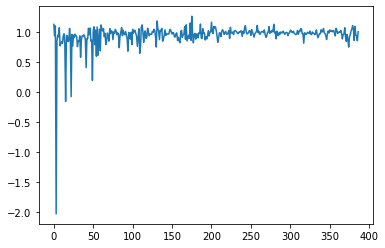

In [72]:
(pd.Series(market_factor_rank_return)+1).plot()

In [73]:
market_factor_rank_return

[0.12127306079366651,
 -0.06812466700099318,
 0.09617834146408591,
 -3.03427481522533,
 -0.15411719631872678,
 -0.05999040433054636,
 -0.08449293276655899,
 0.06553138481335148,
 -0.23664185467926063,
 -0.18673113596679736,
 -0.16697947140962968,
 -0.19457007949614233,
 -0.07242239118663829,
 -0.03556765099182242,
 -0.2053524029793229,
 -1.1613908395778045,
 -0.0632707300892655,
 -0.06645828837285413,
 -0.16552068838147094,
 -0.15508172283233643,
 0.054250439015449556,
 -0.11424731200192613,
 -1.0823413582348014,
 -0.04598526550536316,
 -0.23661849020490652,
 -0.05844527020817685,
 -0.09882119415771205,
 -0.042165424184314536,
 -0.06636727519641307,
 -0.07765030794743856,
 -0.2491712852145947,
 -0.15795163989661332,
 -0.15813900968628292,
 -0.0695994985401364,
 -0.42585146625108267,
 -0.13572845920910237,
 -0.07078457456690074,
 -0.07900895746926381,
 -0.05341976550415355,
 -0.06567228299868455,
 -0.12903788893324525,
 -0.6006536670581315,
 -0.11513290535231026,
 -0.11647806922323524,
